In [1]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])
        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))
        
    shuffle(img_labels)
    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.

    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    
    img_arrays = np.expand_dims(img_arrays, axis =3)    
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(train_data_path, test_data_path, train_list,
                                                         test_list, img_h, img_w)

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

batch_size = 8
epochs = 50
n_base = 32
learning_rate = 0.0001


def model(img_ch, img_width, img_height):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

## Taks6A) Read the skin images with the size of 128*128 and train the AlexNet model with the following parameter: batch size = 8; epochs = 50; n_base(Base) = 32; learning rate = 0.0001, and Adam as optimizer. Evaluate the model performance.

In [3]:
clf_6a = model(1, 128, 128)
clf_6a.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6a_hist = clf_6a.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.05,
    shuffle=False,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

dict_keys(['binary_accuracy', 'loss', 'val_loss', 'val_binary_accuracy'])
Training accuracy 1.0
Validation accuracy 0.78


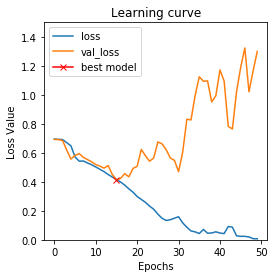

(0, 1)

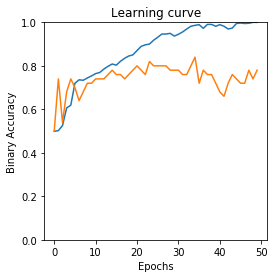

In [5]:
#visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6a_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6a_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6a_hist.history["val_loss"]),
np.min(clf_6a_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6a_hist.history.keys())
print("Training accuracy", clf_6a_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6a_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6a_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6a_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### Evaluate the model performance:
The traing accuracy is 1.0 after the last epoch, while the validation accuracy is only 0.7. Furthermore, it can be seen that the validation and training loss diverge after 12 epochs. While the training loss keeps decreasing, the validation loss is increasing. This suggests that the model is in overfitting. By looking at the accuracies over the number of epochs, it can be seen that the curves for the training and validation diverge, which again suggests overfitting of the model.

## Taks6B) Change the n_base parameter as 16 and 8 and run the model for 50 epochs. How do you interpret the observe results? Now, with n_base = 8, after each of the dense layer add a “drop out layer” with a drop out rate of 0.4 and train the model for 50 epochs. What is the effect of the drop out layer? Increase the number of epochs to 150. How do you explain the effect of increasing the number of epochs?

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
activation_88 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_89 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 64)      

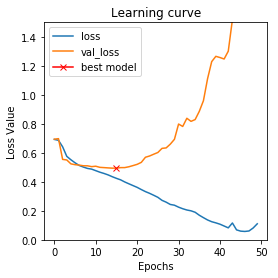

(0, 1)

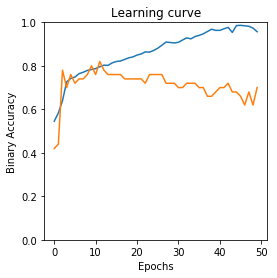

In [26]:
n_base = 16

clf_6b_16 = model(1, 128, 128)
clf_6b_16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6b_16_hist = clf_6b_16.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.05,
    shuffle=False,
)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_16_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6b_16_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6b_16_hist.history["val_loss"]),
np.min(clf_6b_16_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6b_16_hist.history.keys())
print("Training accuracy", clf_6b_16_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6b_16_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_16_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6b_16_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_96 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_97 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 32)      

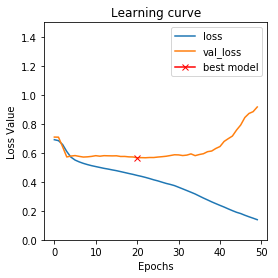

(0, 1)

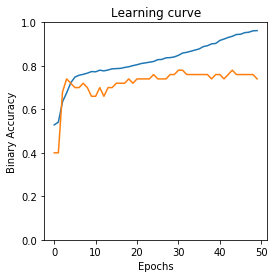

In [27]:
n_base = 8

clf_6b_8 = model(1, 128, 128)
clf_6b_8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6b_8_hist = clf_6b_8.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.05,
    shuffle=False,
)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6b_8_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6b_8_hist.history["val_loss"]),
np.min(clf_6b_8_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6b_8_hist.history.keys())
print("Training accuracy", clf_6b_8_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6b_8_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6b_8_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

## How do you interpret the observe results?

The difference between the validation and training curves is higher in the model with a n_base=16 than it is for n_base=8. Since the first model has about twice as many parameter and a large difference between validation curves and training curves suggests overfitting, it seems like the model with n_base=8 is less overfitted than the other model.

In [29]:
from tensorflow.keras.layers import Dropout

def model_with_droupout(img_ch, img_width, img_height, n_filters_init, do_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_filters_init, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(do_rate))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Dropout(do_rate))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_120 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_121 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 32)      

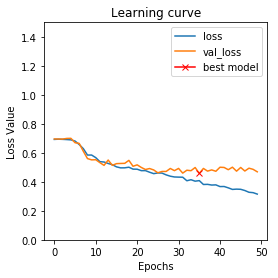

(0, 1)

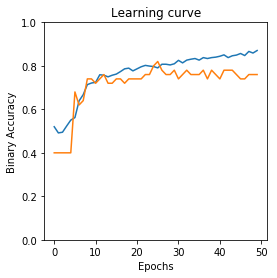

In [33]:
n_base = 8

clf_6b_8_do = model_with_droupout(1, 128, 128, n_base, 0.4)
clf_6b_8_do.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6b_8_do_hist = clf_6b_8_do.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.05,
    shuffle=False,
)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_do_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6b_8_do_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6b_8_do_hist.history["val_loss"]),
np.min(clf_6b_8_do_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6b_8_do_hist.history.keys())
print("Training accuracy", clf_6b_8_do_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6b_8_do_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_do_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6b_8_do_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### What is the effect of the drop out layer?

The dropout decreases the difference between the vaidation and training loss curves. However, the validation accuracy did not change substantially. The training accuracy decreased. So the model is less overfitted. 

### Increase the number of epochs to 150. How do you explain the effect of increasing the number of epochs?¶

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_152 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_153 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 32, 32)      

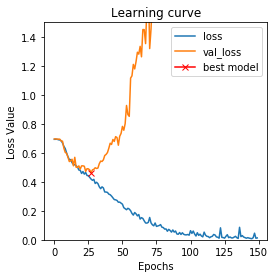

(0, 1)

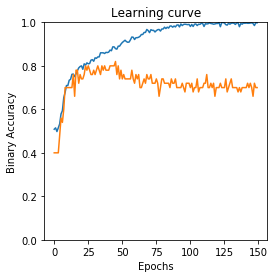

In [39]:
epochs = 150

clf_6b_8_do = model_with_droupout(1, 128, 128, n_base, 0.4)
clf_6b_8_do.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])
clf_6b_8_do_hist = clf_6b_8_do.fit(x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.05,
    shuffle=False,
)

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_do_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6b_8_do_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6b_8_do_hist.history["val_loss"]),
np.min(clf_6b_8_do_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6b_8_do_hist.history.keys())
print("Training accuracy", clf_6b_8_do_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6b_8_do_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6b_8_do_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6b_8_do_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### How do you explain the effect of increasing the number of epochs?¶
The traing curve with dropout takes longer to converge, however, after a high number of epochs, it converges to a loss of 0 and accuracy of 1, indicating that the network "memorized" all of the training images.

## Task6C) Remove the drop out layers, set the parameters n_base=8, learning_rate = 1e-5 and run the model for n_epochs =150,350 epochs. How changing the learning rate parameter affect model performance?

In [15]:
def model_6c(img_ch, img_width, img_height, n_filters_init):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_filters_init, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

In [42]:
batch_size = 8
epochs = 150
n_base = 8
learning_rate = 0.00001

clf_6c_150e = model_6c(1, 128, 128, n_base)

clf_6c_150e.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6c_150e_hist = clf_6c_150e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_160 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_161 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.79263157
Validation accuracy 0.74


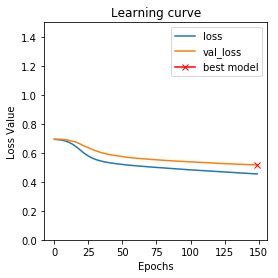

(0, 1)

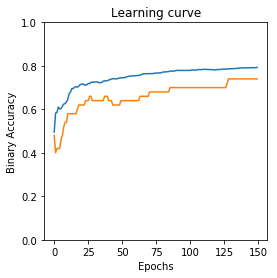

In [43]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6c_150e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6c_150e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6c_150e_hist.history["val_loss"]),
np.min(clf_6c_150e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6c_150e_hist.history.keys())
print("Training accuracy", clf_6c_150e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6c_150e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6c_150e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6c_150e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

In [44]:
batch_size = 8
epochs = 350
n_base = 8
learning_rate = 0.00001

clf_6c_350e = model_6c(1, 128, 128, n_base)

clf_6c_350e.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6c_350e_hist = clf_6c_350e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_168 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_169 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.90105265
Validation accuracy 0.8


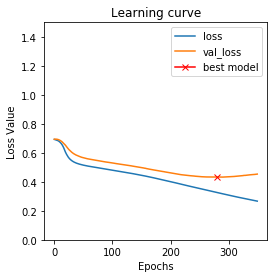

(0, 1)

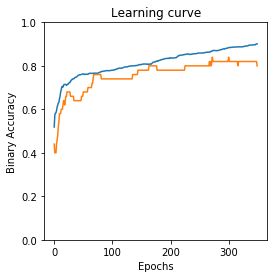

In [45]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6c_350e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6c_350e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6c_350e_hist.history["val_loss"]),
np.min(clf_6c_350e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6c_350e_hist.history.keys())
print("Training accuracy", clf_6c_350e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6c_350e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6c_350e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6c_350e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### How changing the learning rate parameter affect model performance?

With the smaller learning rate, the model converges slower. However, it seems like the model does not overft as much with the smaller learning rate. The difference between loss values for validation and test is smaller than for the higher learning rate. The training and validation accuracy increases slightly for more epochs. 

## Taks6D) For the fix parameters of learning_rate = 1e-5, n_base=8, n_epochs = 150, change the batch size parameters as 2,4,8. Do you see any significant differences in model performance?

In [46]:
batch_size = 4
epochs = 150
n_base = 8
learning_rate = 0.00001

clf_6d_150e = model_6c(1, 128, 128, n_base)

clf_6d_150e.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6d_150e_hist = clf_6d_150e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_176 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_177 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.8210526
Validation accuracy 0.78


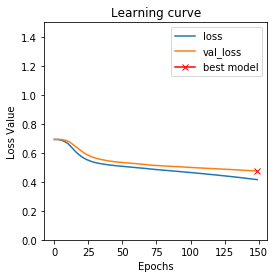

(0, 1)

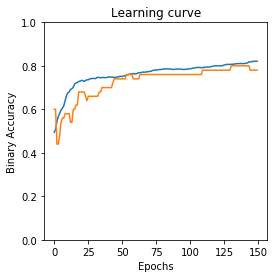

In [47]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6d_150e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6d_150e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6d_150e_hist.history["val_loss"]),
np.min(clf_6d_150e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6d_150e_hist.history.keys())
print("Training accuracy", clf_6d_150e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6d_150e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6d_150e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6d_150e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

In [48]:
batch_size = 2
epochs = 150
n_base = 8
learning_rate = 0.00001

clf_6d_150e = model_6c(1, 128, 128, n_base)

clf_6d_150e.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6d_150e_hist = clf_6d_150e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_184 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_185 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.82
Validation accuracy 0.76


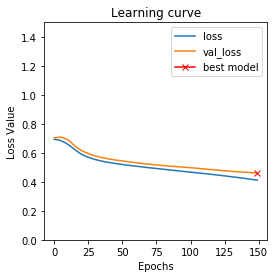

(0, 1)

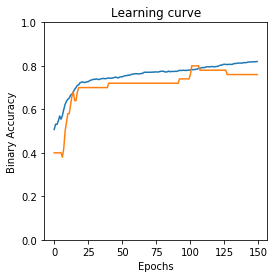

In [49]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6d_150e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6d_150e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6d_150e_hist.history["val_loss"]),
np.min(clf_6d_150e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6d_150e_hist.history.keys())
print("Training accuracy", clf_6d_150e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6d_150e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6d_150e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6d_150e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### Do you see any significant differences in model performance?¶
batch_size = 8: Validation accuracy = 0.74;<br>
batch_size = 4: Validaiion accuracy = 0.78;<br>
batch_size = 2: Validation accuracy = 0.76;<br>


There is no substantial difference in validation accuracies. However, the accuracy for the model trained with batch_size =4 performs slightly better than the rest. This could be by chance, though.

## Task6E) By finding the optimum values of batch_size, learning rate, and base parameters, train the model for 100 epochs and make sure it is not overfitted. Report the classification accuracy of the model. Then, for this model, only change the optimizer algorithm from Adam to SGD and RMSprop and compare the observed results.

In [50]:
# defining the model based on the previous experiments, so batch_size = 4, n_base=8, LR=1e-05
def model_6e(img_ch, img_width, img_height, n_filters_init):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_filters_init, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_filters_init*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

batch_size = 4
epochs = 100
n_base = 8
learning_rate = 0.00001

clf_6e = model_6c(1, 128, 128, n_base)

clf_6e.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6e_hist = clf_6e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_192 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_193 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.7894737
Validation accuracy 0.76


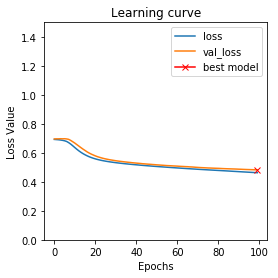

(0, 1)

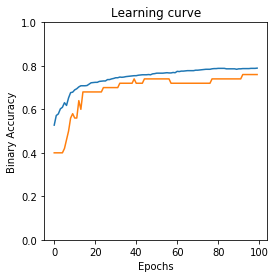

In [51]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6e_hist.history["val_loss"]),
np.min(clf_6e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6e_hist.history.keys())
print("Training accuracy", clf_6e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### By finding the optimum values of batch_size, learning rate, and base parameters, train the model for 100 epochs and make sure it is not overfitted. Report the classification accuracy of the model.

We chose the parameters based on the previous experiments. Thus, the parameters were set as follows:

n_base = 8 <br>
epochs = 100 <br>
learning_rate = 1e-05 <br>
batch_size = 4 <br>

The difference between train and validation accuracy is very small, thus it does not seem like the model is overfitted. The validation accuracy is 0.76.

### Then, for this model, only change the optimizer algorithm from Adam to SGD and RMSprop and compare the observed results.

In [57]:
# SGD

clf_6e = model_6c(1, 128, 128, n_base)

clf_6e.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6e_hist = clf_6e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_216 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_217 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.50526315
Validation accuracy 0.4


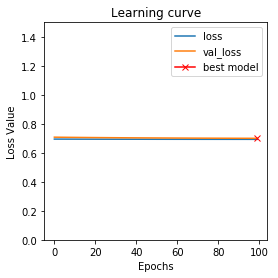

(0, 1)

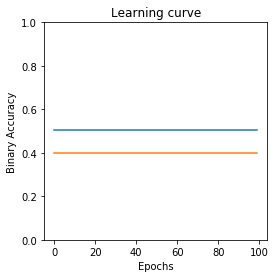

In [58]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6e_hist.history["val_loss"]),
np.min(clf_6e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6e_hist.history.keys())
print("Training accuracy", clf_6e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

In [59]:
# RMSprop

clf_6e = model_6c(1, 128, 128, n_base)

clf_6e.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6e_hist = clf_6e.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_224 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_225 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.7663158
Validation accuracy 0.7


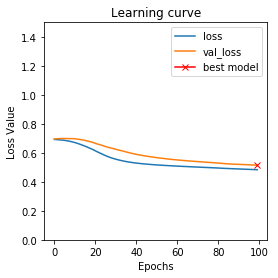

(0, 1)

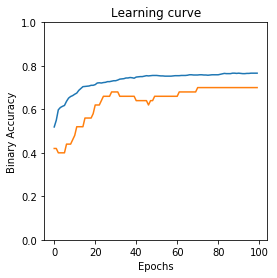

In [60]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6e_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6e_hist.history["val_loss"]),
np.min(clf_6e_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6e_hist.history.keys())
print("Training accuracy", clf_6e_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6e_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6e_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6e_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### Compare the observed results.¶

The model with the SGD optimizer did not train at all. The model with RMSprop as the optimizer trained, but performed worse than adam and additionally had a higher difference between training and validation accuracy. It can be seen that the parameters have to be optimized for each optimizer. In this case, the learning rate is likely the hyperpatameter that affects the classification performance the most.

## Task6F) “Binary cross entropy (BCE)” is not the only loss function for a binary classification task. Run the code again by changing the loss func into “hinge” with Adam optimizer. What is the major difference between the “BCE” and “hinge” in terms of model performance? Please note, you need to have class labels as [-1, 1] therefore, you need to change the labels as :

In [62]:
y_test[y_test == 0] = -1
y_train[y_train == 0] = -1

In [63]:
clf_6f = model_6c(1, 128, 128, n_base)

clf_6f.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.Hinge(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_6f_hist = clf_6f.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_split=0.05,
                                    shuffle=False,                                    
                                    )

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_232 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_233 (Activation)  (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 32, 32, 32)      

dict_keys(['loss', 'val_loss', 'binary_accuracy', 'val_binary_accuracy'])
Training accuracy 0.3863158
Validation accuracy 0.3


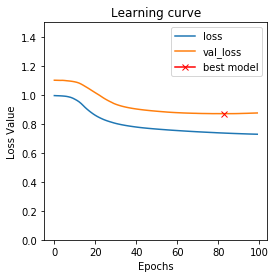

(0, 1)

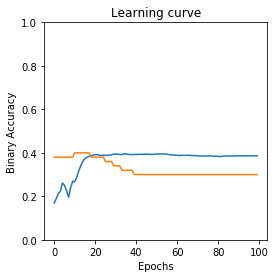

In [65]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6f_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_6f_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_6f_hist.history["val_loss"]),
np.min(clf_6f_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_6f_hist.history.keys())
print("Training accuracy", clf_6f_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_6f_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_6f_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_6f_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### What is the major difference between the “BCE” and “hinge” in terms of model performance?

The hinge loss doesn't perform very well. The validation accuracy is 0.3 compared to 0.7 with the BCE. 

## Taks7A) The purpose of this task is to implement an architecture from scratch. You have to implement the architecture of the VGG16 model, as shown in the following figure. Please note 3 ×3 represents the size of the convolutional kernels, “Base” shows the number of feature maps, “pool/2” indicates the max-pooling operator, and “fc 64” means fully connected (dense) layer with 64 neurons.

In [5]:
# implementation of the VGG16 

# defining the model based on the previous experiments, so batch_size = 4, n_base=8, LR=1e-05
def model_7a(img_ch, img_width, img_height, n_base):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(filters=2*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=2*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    
    
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))  

    
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

## Task7B) Load the Skin data set with the size of 128*128. For the following fixed parameters, compile the model and find the optimum value of the learning rate that will lead to reliable classification performance over the validation set. What is the proper learning rate?

In [6]:
y_test[y_test == -1] = 0
y_train[y_train == 0] = 0

In [9]:
batch_size = 8
epochs = 100
n_base = 8
learning_rate = 0.00001

clf_7b = model_7a(1, 128, 128, n_base)

clf_7b.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_7b_hist = clf_7b.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
activation_17 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_18 (Activation)   (None, 64, 64, 16)       

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.804
Validation accuracy 0.83


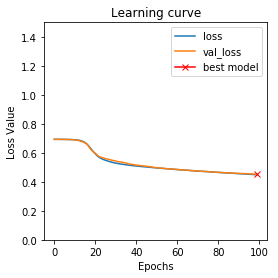

(0, 1)

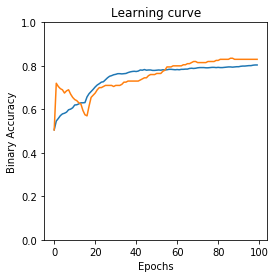

In [10]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_7b_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_7b_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_7b_hist.history["val_loss"]),
np.min(clf_7b_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_7b_hist.history.keys())
print("Training accuracy", clf_7b_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_7b_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_7b_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_7b_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### What is the proper learning rate?

After testing multiple learning rates, we found that 10e-5 works the best.



## For the same setting as task6C (only for n_epoch=150) compare the classification accuracy over the validation set between the AlexNet and VGG16 models. How do you justify the observed results?

In [12]:
batch_size = 8
epochs = 150
n_base = 8
learning_rate = 0.00001

clf_7c = model_7a(1, 128, 128, n_base)

clf_7c.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_7c_hist = clf_7c.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_48 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
activation_49 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_50 (Activation)   (None, 64, 64, 16)       

In [17]:
clf_7c_alex = model_6c(1, 128, 128, n_base)
clf_7c_alex.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])
clf_7c_alex_hist = clf_7c_alex.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 128, 128, 8)       80        
_________________________________________________________________
activation_72 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_73 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 32)       

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.822
Validation accuracy 0.84


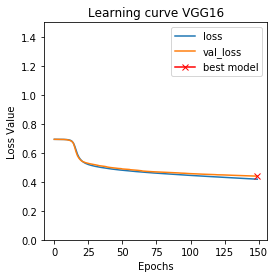

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.79
Validation accuracy 0.745


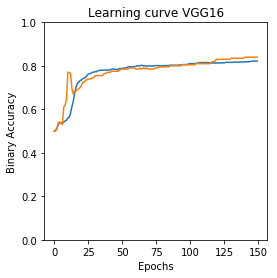

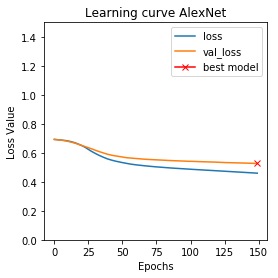

(0, 1)

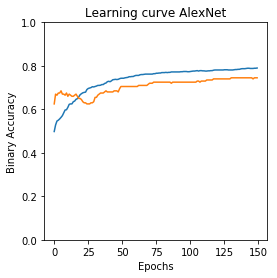

In [18]:
# visualize result of VGG16

plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16")
plt.plot(clf_7c_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_7c_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_7c_hist.history["val_loss"]),
np.min(clf_7c_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_7c_hist.history.keys())
print("Training accuracy", clf_7c_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_7c_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16")
plt.plot(clf_7c_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_7c_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

# visualize result of AlexNet

plt.figure(figsize=(4, 4))
plt.title("Learning curve AlexNet")
plt.plot(clf_7c_alex_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_7c_alex_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_7c_alex_hist.history["val_loss"]),
np.min(clf_7c_alex_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_7c_alex_hist.history.keys())
print("Training accuracy", clf_7c_alex_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_7c_alex_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve AlexNet")
plt.plot(clf_7c_alex_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_7c_alex_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### compare the classification accuracy over the validation set between the AlexNet and VGG16 models. How do you justify the observed results?

The VGG16 has a validation accuracy of 0.84, while the AlexNet has a validation accuracy of 0.745. When looking at the learning curves, one can see that the curve of the training accuracy of the AlexNet is higher than the validation accuracy. By looking at the accuracy curves in VGG16, one can see that they are closer together. Furthermore, the VGG16 has fewer parameters. Thus, the AlexNet is probably overfitting the data and consequently performs worse on the validation set then the VGG16.

## Task7D) Change the parameter n_base to 16. Train the model for 100 epochs with LR = 1e-5 and batch size of 8. Does increasing the number of feature maps affect model performance? Then, add a dropout layer with a rate of 0.2 for each of the dense layer. What was the effect of adding the dropout layer?

In [20]:
batch_size = 8
epochs = 100
n_base = 16
learning_rate = 0.00001

clf_7d = model_7a(1, 128, 128, n_base)

clf_7d.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_7d_hist = clf_7d.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
activation_96 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
activation_97 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_98 (Activation)   (None, 64, 64, 32)       

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.833
Validation accuracy 0.815


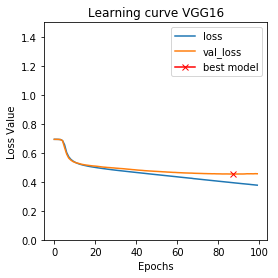

(0, 1)

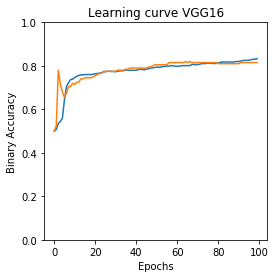

In [21]:
# visualize result of VGG16 with base_n = 16 

plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16")
plt.plot(clf_7d_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_7d_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_7d_hist.history["val_loss"]),
np.min(clf_7d_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_7d_hist.history.keys())
print("Training accuracy", clf_7d_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_7d_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16")
plt.plot(clf_7d_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_7d_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))



### Does increasing the number of feature maps affect model performance? 
The validation accuracy decreased slightly and by looking at the loss curves, it can also be seen that the difference between the training and the validation loss is higher than for the model with n_base = 8. Since we increased the number of parameters by more than 3 times, the network is likely overfitting the data. Also, we only trained with 100 instead of 150 epochs, which might deteriorate the accuracy. 

In [24]:
# implementation of the VGG16 with dropout
from tensorflow.keras.layers import Dropout

# defining the model based on the previous experiments, so batch_size = 4, n_base=8, LR=1e-05
def model_7d(img_ch, img_width, img_height, n_base, dp_rate):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(filters=2*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=2*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    
    
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=4*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))  

    
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters=8*n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) 
    

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dropout(dp_rate))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dp_rate))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

In [32]:
clf_7d_do = model_7d(1, 128, 128, n_base, dp_rate=0.2)

clf_7d_do.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_7d_do_hist = clf_7d_do.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 128, 128, 16)      160       
_________________________________________________________________
activation_173 (Activation)  (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
activation_174 (Activation)  (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_175 (Activation)  (None, 64, 64, 32)      

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.806
Validation accuracy 0.84


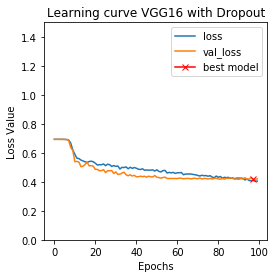

(0, 1)

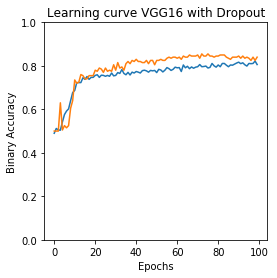

In [33]:
# visualize result of VGG16 with base_n = 16 and Dropout

plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 with Dropout")
plt.plot(clf_7d_do_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_7d_do_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_7d_do_hist.history["val_loss"]),
np.min(clf_7d_do_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_7d_do_hist.history.keys())
print("Training accuracy", clf_7d_do_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_7d_do_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 with Dropout")
plt.plot(clf_7d_do_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_7d_do_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

### What was the effect of adding the dropout layer?¶
After adding the dropout layers, the validation accuracy was better than the training accuracy. It seems to have reduced the overfitting of the model. 

## Task7E) So far, you classified the Skin cancer dataset with 3 different models named as LeNet, AlexNet as well VGG16. In general, what is the difference between these three models? Which of them yields more accurate classification results? Why? To evaluate the model performance, how do you assess the loss values? How can you prevent the model training from overfitting?

The VGG16 with base_n=8 to yielded the best validation accuracy and lowest validation loss. The leNet has approximately 4M parameters, the AlexNet has approximately 500.000 parameters and the VGG16 has approximately 300.000 parameters. Furthermore, the Architecure varies between the models. The VGG16 has the most number of convolutional layers and smaller dense layers. <br>

By looking at the loss curves, it seems like the LeNet overfits the most, the AlexNet overfitted less, but still more than the VGG16. Thus, the number of parameters in the VGG seems to be suffitient to classify the images correctly. 

The training loss and validation loss curves must be compared to each other, in order to check if they converge and to check if the model overfits the data. Furthermore, on can compare the loss value to different models, if the models use the same loss function and are trained and tested on the same data. The lower the loss, the better.

Dropout layers can be used to prevent overfitting. Also, batch normalization can help with overfitting. 

## Task8) Train the VGG16 model developed in Task7 with the following parameters to classify two types of bone fractures from “Bone” dataset. Please note the size of the Bone images is quite large, so that it would take a longer time to read and load all the images.

In [36]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
    The image file name.
    pat1 : Str
    A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
    A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array
    Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label

def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
    Path to the data directory
    train_list : List
    A list containing the name of the images.
    img_h : Int
    image height to be resized to.
    img_w : Int
    image width to be resized to.
    Returns
    -------
    img_labels : Nested List
    A nested list containing the loaded images along with their
    correcponding labels.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'AFF', 'NFF')])
        if item[0] % 100 == 0:
            print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))
        
    shuffle(img_labels)
    return img_labels

def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
    nested list of image arrays with corresponding class labels.
    img_h : Int
    Image height.
    img_w : Int
    Image width.

    Returns
    -------
    img_arrays : Numpy array
    4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
    1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    
    img_arrays = np.expand_dims(img_arrays, axis =3)    
    return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab1/Bone/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(train_data_path, test_data_path, train_list,
                                                         test_list, img_h, img_w)

Reading: 0/1072 of train images
Reading: 100/1072 of train images
Reading: 200/1072 of train images
Reading: 300/1072 of train images
Reading: 400/1072 of train images
Reading: 500/1072 of train images
Reading: 600/1072 of train images
Reading: 700/1072 of train images
Reading: 800/1072 of train images
Reading: 900/1072 of train images
Reading: 1000/1072 of train images
Reading: 0/140 of train images
Reading: 100/140 of train images


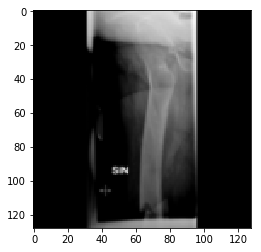

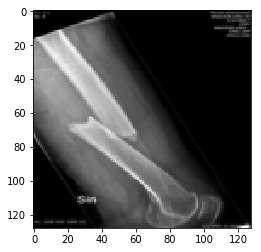

In [52]:
# look at example images
x_train[10].shape
plt.imshow(x_train[500][:,:,0], cmap="gray")
plt.show()
plt.imshow(x_train[501][:,:,0], cmap="gray")
plt.show()

In [56]:
batch_size = 8
learning_rate = 0.000005
n_base_8 = 8
n_base_16 = 16
epochs = 100

clf_8_base8 = model_7a(1, 128, 128, n_base_8)

clf_8_base8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_8_base8_hist = clf_8_base8.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

# train model with n_base = 16
clf_8_base16 = model_7a(1, 128, 128, n_base_16)

clf_8_base16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

clf_8_base16_hist = clf_8_base16.fit(
                                    x=x_train,
                                    y=y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test),
                                    shuffle=False,                                    
                                    )

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
activation_221 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 128, 128, 8)       584       
_________________________________________________________________
activation_222 (Activation)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_223 (Activation)  (None, 64, 64, 16)      

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.8125
Validation accuracy 0.74285716


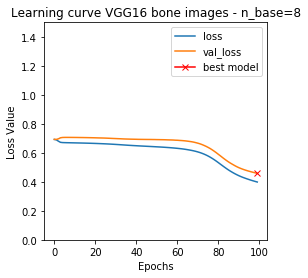

dict_keys(['loss', 'val_loss', 'val_binary_accuracy', 'binary_accuracy'])
Training accuracy 0.92817163
Validation accuracy 0.9


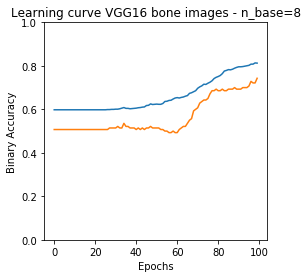

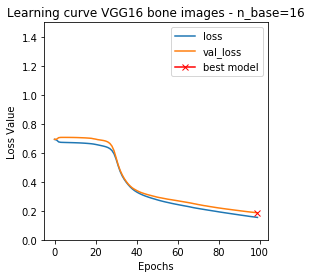

(0, 1)

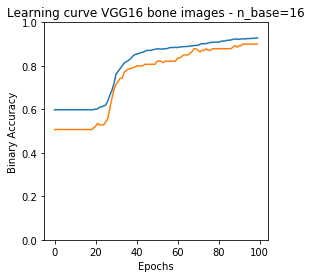

In [57]:
# visualize result of VGG16 with base_n = 8 on bone images

plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 bone images - n_base=8")
plt.plot(clf_8_base8_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_8_base8_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_8_base8_hist.history["val_loss"]),
np.min(clf_8_base8_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_8_base8_hist.history.keys())
print("Training accuracy", clf_8_base8_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_8_base8_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 bone images - n_base=8")
plt.plot(clf_8_base8_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_8_base8_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))



# visualize result of VGG16 with base_n = 16 on bone images
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 bone images - n_base=16")
plt.plot(clf_8_base16_hist.history["loss"], label="loss") #loss is training loss
plt.plot(clf_8_base16_hist.history["val_loss"], label="val_loss") #val_loss is validation loss
plt.plot(np.argmin(clf_8_base16_hist.history["val_loss"]),
np.min(clf_8_base16_hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.ylim((0,1.5))

plt.legend();
print(clf_8_base16_hist.history.keys())
print("Training accuracy", clf_8_base16_hist.history["binary_accuracy"][-1])
print("Validation accuracy", clf_8_base16_hist.history["val_binary_accuracy"][-1])
plt.show()

# plotting accuracy curves
plt.figure(figsize=(4, 4))
plt.title("Learning curve VGG16 bone images - n_base=16")
plt.plot(clf_8_base16_hist.history["binary_accuracy"], label="binary_accuracy") # training accuracy
plt.plot(clf_8_base16_hist.history["val_binary_accuracy"], label="val_binary_accuracy") # validation accuracy
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.ylim((0,1))

##  Task9) With the implemented VGG models, which of the Skin/Bone image sets classified more accurately? Why? How do you make sure that achieved results are reliable?

The VGG is more accurare on the bone images, since the validation accuracy is 0.9 compared to 0.84 for the skin dataset. However, the model trained with the bone image set is slightly overfitted. In order to make sure the achieved results are reliable, one could apply a k-fold cross validation. 

# Task 10 is done in a seperare notebook!